In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [3]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-4)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=ReLU(),
    momentum=('Standard',1e-5)
)


net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)
net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)

('Standard', 1e-05)
('Standard', 1e-05)
('Standard', 1e-05)


In [3]:
seed = 3

net = create_all_net(
    seed=seed,
    loss="MSE",
    batch_size=1,
    input_size=len(X_train[0]),
    num_layer=3,
    layers_size=[16,16,3],
    starting=["Range_random", "Range_random", "Range_random"],
    starting_range=[(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)],
    activations=["ReLU", "ReLU", "Identity"],
    regularizers=["L2", "None", "L2"],
    regularizers_lambda=[1e-6,0,1e-6],
    momentums=[("Standard", 1e-5), ("None", 0), ("Standard", 1e-5)],
    eta=1e-4
)

In [55]:

regularizers=["L2", "None", "L2"]
regularizers_lambda=[1e-6,0,1e-6]
regularizers_ = []

for i, reg in enumerate(regularizers):
    print(reg)
    if reg != "None":
        regularizers_.append(eval(reg)(lambda_=regularizers_lambda[i]))
    else:
        regularizers_.append(None)

for i in regularizers_:
    print(type(i))

L2
None
L2
<class 'regularizers.L2'>
<class 'NoneType'>
<class 'regularizers.L2'>


In [8]:
print(net)
type(net.loss)


Network: 3 layers 
Loss: MSE


str

Epochs:  42%|████▏     | 1056/2500 [02:22<03:14,  7.42it/s]


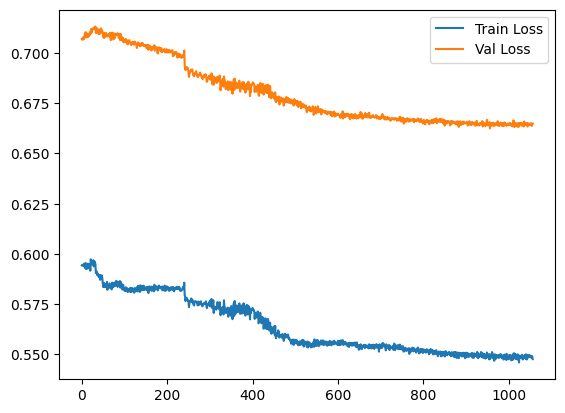

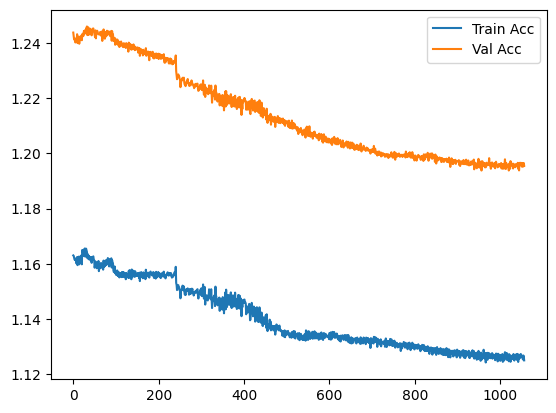

Epochs:  16%|█▌        | 397/2500 [00:52<04:37,  7.59it/s]


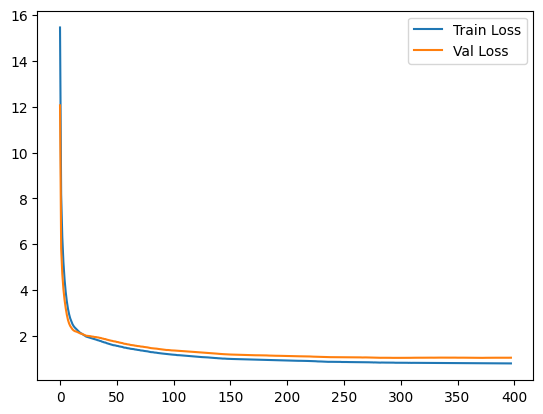

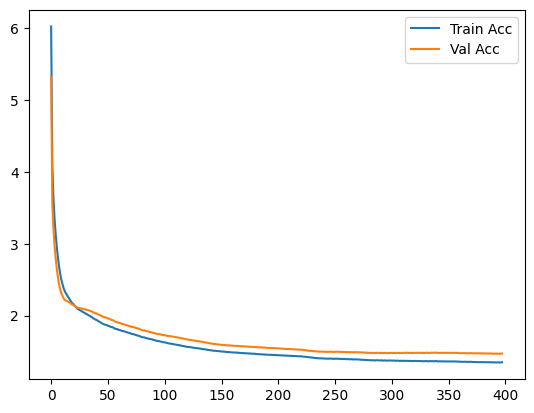

Epochs:  66%|██████▋   | 1659/2500 [03:47<01:55,  7.29it/s]


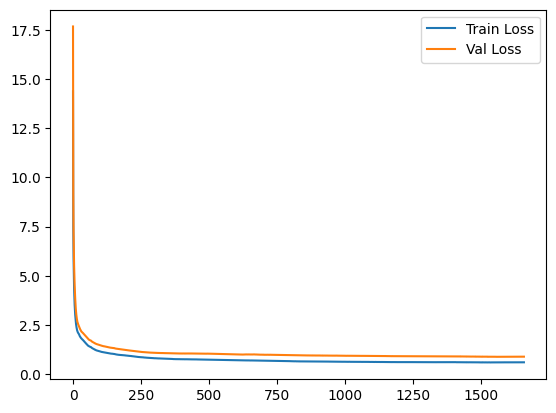

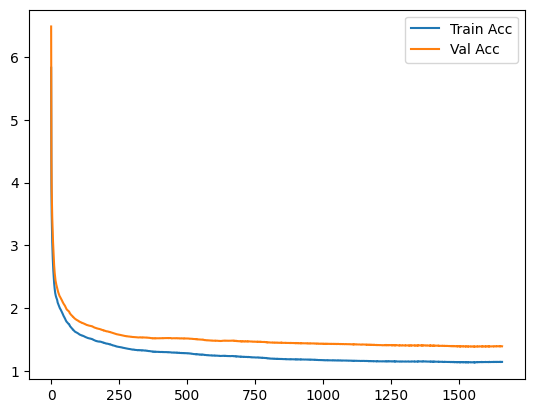

Epochs:  87%|████████▋ | 2170/2500 [04:15<00:38,  8.48it/s]


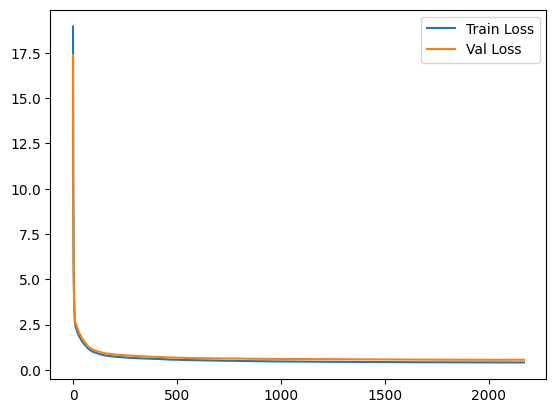

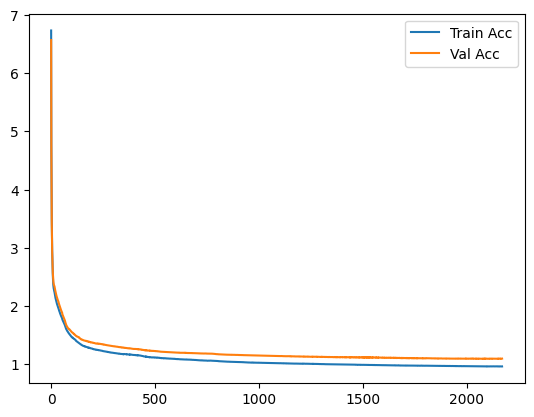

Epochs:  62%|██████▏   | 1556/2500 [03:09<01:55,  8.20it/s]


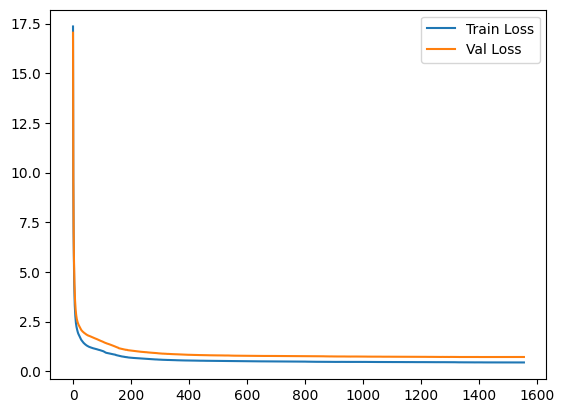

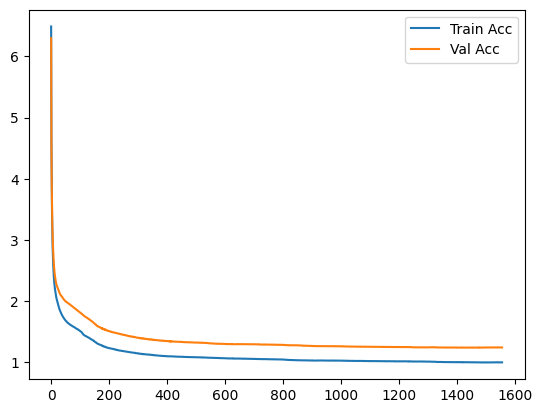

Epochs:  70%|███████   | 1759/2500 [03:25<01:26,  8.54it/s]


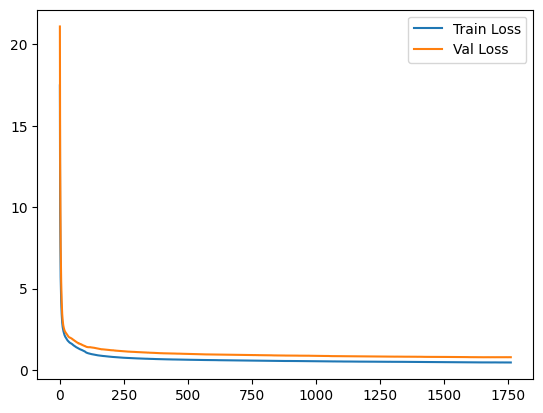

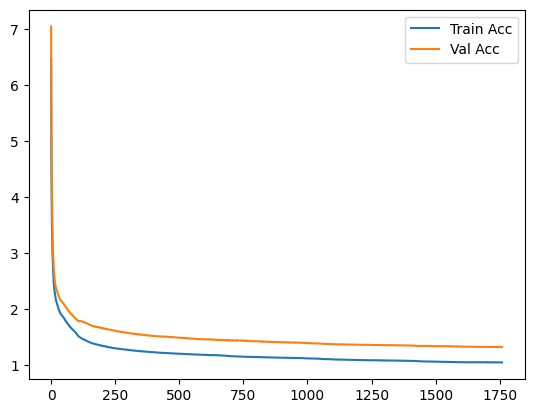

{'tr_loss': 0.5508608260907796, 'tr_metric': 1.1091999840174815, 'val_loss': 0.7745477522957046, 'val_metric': 1.2869652074337157}


In [5]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

In [16]:
import itertools

# define the hyperparameters
losses = ["MSE"]
#batch_sizes = [1, 10]
layers_sizes = [[16,16,3]]
startings = ["Range_random"]
startings_range = [(-0.5,0.5)]

activations = ["ReLU"]
regularizers = ["L1"]
regularizers_lambda = [1e-4, 1e-6]
momentums = [('Standard',1e-6)]
etas = [1e-4]

# create a list of all the possible combinations
hyperparameters = [losses, layers_sizes, startings,
                activations, regularizers, regularizers_lambda,
                momentums, startings_range, etas]
hyperparameters = list(itertools.product(*hyperparameters))
hyperparameters






[('MSE',
  [16, 16, 3],
  'Range_random',
  'ReLU',
  'L1',
  0.0001,
  ('Standard', 1e-06),
  (-0.5, 0.5),
  0.0001),
 ('MSE',
  [16, 16, 3],
  'Range_random',
  'ReLU',
  'L1',
  1e-06,
  ('Standard', 1e-06),
  (-0.5, 0.5),
  0.0001)]

In [25]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[16, 16, 3]],
    'activations': ["ReLU"],
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L1"],
    'regularizers_lambda': [1e-4, 1e-6],
    'momentums': [('Standard', 1e-6)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

{'losses': 'MSE', 'layers_sizes': [16, 16, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L1', 'regularizers_lambda': 0.0001, 'momentums': ('Standard', 1e-06), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [16, 16, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L1', 'regularizers_lambda': 1e-06, 'momentums': ('Standard', 1e-06), 'etas': 0.0001}


In [37]:
for i in all_dics:
    print(*i.values())

MSE [16, 16, 3] ReLU Range_random (-0.5, 0.5) L1 0.0001 ('Standard', 1e-06) 0.0001
MSE [16, 16, 3] ReLU Range_random (-0.5, 0.5) L1 1e-06 ('Standard', 1e-06) 0.0001


In [29]:
losses_ = "MSE"
layers_sizes_ = [16,16,3]

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(layers_sizes[0])):
        activations_.append(combination['activations'] if i != len(layers_sizes[0])-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")





['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[0.0001, 0.0001, 0.0001]
[('Standard', 1e-06), ('Standard', 1e-06), ('Standard', 1e-06)]
0.0001


['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Standard', 1e-06), ('Standard', 1e-06), ('Standard', 1e-06)]
0.0001




In [71]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

In [72]:
seed = 3

for h in range(len(hyperparameters)):
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(layers_sizes[0])):
        activations_.append(combination['activations'] if i != len(layers_sizes[0])-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=3,
        layers_size=[16,16,3],
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=1000,
        patience=100,
        seed=seed,
        metric=MEE()
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


Epochs:   2%|▏         | 20/1000 [00:03<02:27,  6.66it/s]


KeyboardInterrupt: 

In [38]:
import csv

csv_file_path = '..\statistics\\test.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)

In [70]:
test=[["ciao"]]
test.extend(list(statistics.values()) + list(statistics.values()))
test

[['ciao'],
 0.5508608260907796,
 1.1091999840174815,
 0.7745477522957046,
 1.2869652074337157,
 0.5508608260907796,
 1.1091999840174815,
 0.7745477522957046,
 1.2869652074337157]